# Deep Convolutional Generative Adversarial Network

In [1]:
# Importing required modules

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Keras functions
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.layers import Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import Input, Reshape
from matplotlib import pyplot
from IPython.display import clear_output

# Numpy functions
import numpy
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy import ones
from numpy import asarray

#Torchvision for fast and easy loading and resizing
import torchvision
import torchvision.transforms as transforms

from PIL import Image

In [2]:
# Checking whether GPU is used for training
print('Num GPUs Available:', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


# Setting up the training data and transforming it to right format

In [3]:
# Setting the path of the images (Van Gogh only)
dataset_path = 'C:/Users/david/Desktop/DL Project 2/GAN/artists/'
# Save dataset to this path
saved_path = 'C:/Users/david/Desktop/DL Project 2/GAN/DCGAN Final/training_data3.npy'

In [4]:
# Setting Up/ loading the dataset and saving it
WIDTH = 128
HEIGHT = 128
IMG_SIZE = (WIDTH,HEIGHT)
EPOCHS = 25

#Look for saved file to save time loading and processing images between runs
print("Looking for previously saved file...")

if not os.path.isfile(saved_path):
    print("\n File not found, loading new data...\n")
    dataset = []
    transform_ds = transforms.Compose([transforms.Resize(IMG_SIZE),]) #define transformation
    
    image_folder = torchvision.datasets.ImageFolder(root=dataset_path,
                                     transform=transform_ds)

    print('Number of artworks found: ',len(image_folder))
    
    
    print("Converting images, this will take a few minutes")
    for i in range (len(image_folder)):
        image_array = numpy.array(image_folder[i][0])
        dataset.append(image_array)
        if (i%500 == 0):
            print("Pictures processed: ", i)
            
    print("Saving dataset binary file...")
    dataset = np.array(dataset, dtype=np.float32)
    dataset = (dataset - 127.5) / 127.5 #Normalize to [-1 , 1]
    numpy.save(saved_path, dataset)  #Save processed images as npy file

else:
    print("Data found, loading..")
    dataset = np.load(saved_path) 

print("Dataset length: ", len(dataset))

Looking for previously saved file...
Data found, loading..
Dataset length:  877


In [5]:
# Checking whether dataset has the right shape
dataset[3].shape

(128, 128, 3)

In [6]:
#Use a TensorFlow Dataset to manage the images for easy shuffling, dividing etc
BATCH_SIZE = 32
training_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(9000).batch(BATCH_SIZE)

In [7]:
# Checking information about the entire dataset 
import pandas as pd

artists = pd.read_csv('C:/Users/david/Desktop/DL Project 2/GAN/artists.csv')
artists[['name','genre','paintings']]

,name,genre,paintings
0,Amedeo Modigliani,Expressionism,193
1,Vasiliy Kandinskiy,"Expressionism,Abstractionism",88
2,Diego Rivera,"Social Realism,Muralism",70
3,Claude Monet,Impressionism,73
4,Rene Magritte,"Surrealism,Impressionism",194
5,Salvador Dali,Surrealism,139
6,Edouard Manet,"Realism,Impressionism",90
7,Andrei Rublev,Byzantine Art,99
8,Vincent van Gogh,Post-Impressionism,877
9,Gustav Klimt,"Symbolism,Art Nouveau",117


In [8]:
# this shows us that Van Gogh has the most images
no_of_paintings = artists[['name','paintings','genre']].sort_values(ascending=False, by='paintings')
no_of_paintings

,name,paintings,genre
8,Vincent van Gogh,877,Post-Impressionism
30,Edgar Degas,702,Impressionism
13,Pablo Picasso,439,Cubism
15,Pierre-Auguste Renoir,336,Impressionism
19,Albrecht Dürer,328,Northern Renaissance
46,Paul Gauguin,311,"Symbolism,Post-Impressionism"
16,Francisco Goya,291,Romanticism
31,Rembrandt,262,Baroque
20,Alfred Sisley,259,Impressionism
32,Titian,255,"High Renaissance,Mannerism"


# Setting up the models

In [9]:
# initializing the weights (from a normal distribution)
from keras.initializers import RandomNormal
initialWeights = RandomNormal(mean=0.0, stddev=0.02, seed=None)

Using TensorFlow backend.


In [10]:
# Building the discriminator with 5 Conv2D layers, kernel size of 3x3 and stride of 2x2, with same padding
def build_discriminator(image_shape):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=image_shape, kernel_initializer=initialWeights))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', kernel_initializer=initialWeights))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', kernel_initializer=initialWeights))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', kernel_initializer=initialWeights))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', kernel_initializer=initialWeights))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Building the generator with five deconvolution layers (to generate the images), kernel size 4x4, stride 2x2, same padding
def build_generator(seed_size, channels):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=seed_size))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer=initialWeights))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer=initialWeights))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer=initialWeights))
    # upsample to 64x64
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer=initialWeights))
    # upsample to 128x128
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu', kernel_initializer=initialWeights))
    # output layer
    model.add(Conv2D(channels, (3,3), activation='tanh', padding='same'))
    return model

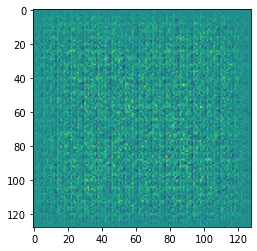

In [11]:
# generate an image based on the current state of the generator model
import matplotlib.pyplot as plt

SEED_SIZE = 100
IMAGE_CHANNELS = 3

generator = build_generator(SEED_SIZE,IMAGE_CHANNELS)

noise = tf.random.normal([1,SEED_SIZE])
generated_image = generator(noise,training=False)

plt.imshow(generated_image[0, :, :, 0])

In [12]:
# classify a random image with the discriminator in its current state
image_shape = (HEIGHT, HEIGHT, IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5000017]], shape=(1, 1), dtype=float32)


# Setting up the training procedure

In [13]:
# define the loss functions for both models
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
# Adam optimizer used for both models
generator_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

In [15]:
# function for saving the output of the generator after each iteration
GENERATED_ROWS = 7
GENERATED_COLS = 7
MARGIN = 2 # Give the images a little frame

def save_images(cnt, noise):
    #Define the "base" of the saved image as a big black canvas
    image_array = np.full(( 
      MARGIN + (GENERATED_ROWS * (WIDTH + MARGIN)), 
      MARGIN + (GENERATED_COLS * (HEIGHT + MARGIN)), 3), 
      0, dtype=np.uint8)
    
    generated_images =  generator.predict(noise)
    
    image_count = 0
    for row in range(GENERATED_ROWS):
        for col in range(GENERATED_COLS):
            r = row * (WIDTH + 2) + MARGIN
            c = col * (HEIGHT + 2) + MARGIN
            image_array[r:r+WIDTH , c:c+HEIGHT] = generated_images[image_count] * 127.5 + 127.5
            image_count += 1
            
    output_path  = os.path.join("C:/Users/david/Desktop/DL Project 2/GAN/DCGAN Final/generated/")
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    filename = os.path.join(output_path,f"train-{cnt}.png")
    im = Image.fromarray(image_array)
    im.save(filename)

In [16]:
# setting up the training sequence

# This goes a bit deeper "behind the scenes" and manually sets the gradients
# instead of letting Keras and TensorFlow set it automatically. This is because
# the two models need to be trained separately
@tf.function
def train_step(images):
    seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(seed, training = True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        
        gradients_of_generator = gen_tape.gradient(
            gen_loss,
            generator.trainable_variables
        )
        gradients_of_discriminator = disc_tape.gradient(
            disc_loss, 
            discriminator.trainable_variables
        )
        
        generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                                generator.trainable_variables))
        
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                                    discriminator.trainable_variables))
        
        return gen_loss, disc_loss

In [17]:
# function for training the models, saving the losses and ouputs
def train(dataset, epochs):
    # Use a fixed seed for the saved images so we can watch their development
    fixed_seed = np.random.normal(0, 1, (GENERATED_ROWS * GENERATED_COLS, SEED_SIZE))
    
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        
        for image_batch in dataset:
            t = train_step(image_batch)
            gen_loss_list.append(t[0])
            disc_loss_list.append(t[1])
            
        g_loss = sum(gen_loss_list) / len(gen_loss_list) #calculate losses
        d_loss = sum(disc_loss_list) / len(disc_loss_list)
        
        print(f'Epoch {epoch+1}, gen loss = {g_loss}, disc loss = {d_loss}')
        
        save_images(epoch, fixed_seed)

# Training the models and checking the output

In [18]:
# train for 300  + 200 epochs
EPOCHS = 200

In [39]:
train(training_dataset, EPOCHS)

Epoch 1, gen loss = 0.888514518737793, disc loss = 1.2645556926727295
Epoch 2, gen loss = 0.8505368232727051, disc loss = 1.2588355541229248
Epoch 3, gen loss = 0.7572676539421082, disc loss = 1.3262913227081299
Epoch 4, gen loss = 0.8292999267578125, disc loss = 1.3540661334991455
Epoch 5, gen loss = 0.7622782588005066, disc loss = 1.3270224332809448
Epoch 6, gen loss = 0.7336721420288086, disc loss = 1.3842171430587769
Epoch 7, gen loss = 0.7495604157447815, disc loss = 1.4700212478637695
Epoch 8, gen loss = 0.7307097315788269, disc loss = 1.3631246089935303
Epoch 9, gen loss = 0.7195372581481934, disc loss = 1.4249627590179443
Epoch 10, gen loss = 0.7944403290748596, disc loss = 1.3172099590301514
Epoch 11, gen loss = 0.8048003911972046, disc loss = 1.3610992431640625
Epoch 12, gen loss = 0.743809163570404, disc loss = 1.4117357730865479
Epoch 13, gen loss = 0.761025607585907, disc loss = 1.4072433710098267
Epoch 14, gen loss = 0.7621364593505859, disc loss = 1.3943666219711304
Epoc

Epoch 116, gen loss = 0.871587872505188, disc loss = 1.1810437440872192
Epoch 117, gen loss = 0.982207179069519, disc loss = 1.161409616470337
Epoch 118, gen loss = 0.7954092025756836, disc loss = 1.26155686378479
Epoch 119, gen loss = 0.7443786263465881, disc loss = 1.4418014287948608
Epoch 120, gen loss = 0.8899677991867065, disc loss = 1.2241078615188599
Epoch 121, gen loss = 0.7974724173545837, disc loss = 1.3534189462661743
Epoch 122, gen loss = 0.8265419602394104, disc loss = 1.3524237871170044
Epoch 123, gen loss = 0.8144415020942688, disc loss = 1.3389877080917358
Epoch 124, gen loss = 0.8892674446105957, disc loss = 1.1897094249725342
Epoch 125, gen loss = 1.0697544813156128, disc loss = 1.0575913190841675
Epoch 126, gen loss = 0.8338190913200378, disc loss = 1.3288878202438354
Epoch 127, gen loss = 0.811289370059967, disc loss = 1.311368703842163
Epoch 128, gen loss = 0.8510688543319702, disc loss = 1.2916076183319092
Epoch 129, gen loss = 0.7061804533004761, disc loss = 1.44

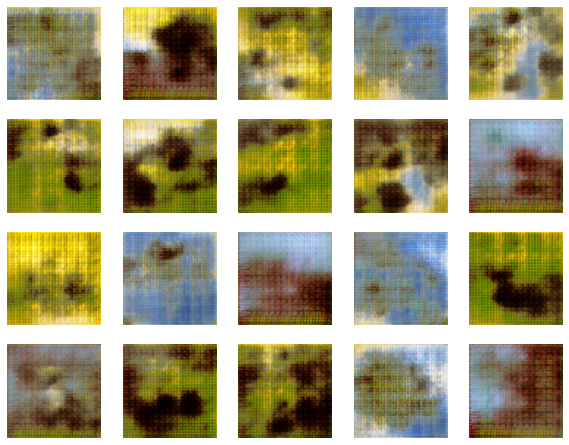

In [25]:
# Generate images with the generator after training
seed2 = tf.random.normal([BATCH_SIZE, SEED_SIZE])
generated_images2 = generator(seed2, training = True)

generated_images2 =0.5 * generated_images2 + 0.5

fig = plt.figure(figsize=(10,10))
for i in range(1,21):
    fig.add_subplot(5,5,i)
    plt.imshow(generated_images2[i])
    plt.axis('off')
    fig.savefig('temp.png', dpi=fig.dpi)

In [45]:
# save the weights of both models
generator.save_weights("DCGAN_VANG_500_Gen.hdf5")
discriminator.save_weights("DCGAN_VANG_500_Disc.hdf5")

In [19]:
generator.load_weights("DCGAN_VANG_500_Gen.hdf5")
discriminator.load_weights("DCGAN_VANG_500_Disc.hdf5")

In [ ]:
#### Additional plots: model structure

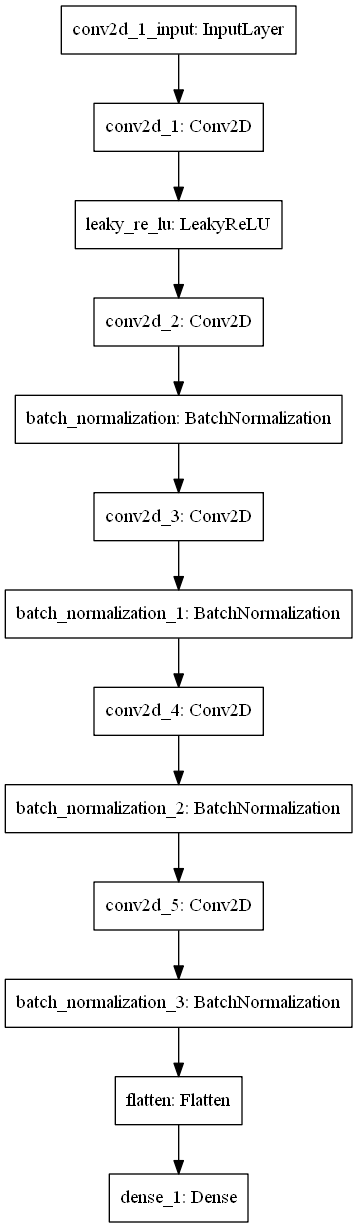

In [26]:
tf.keras.utils.plot_model(
    discriminator,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

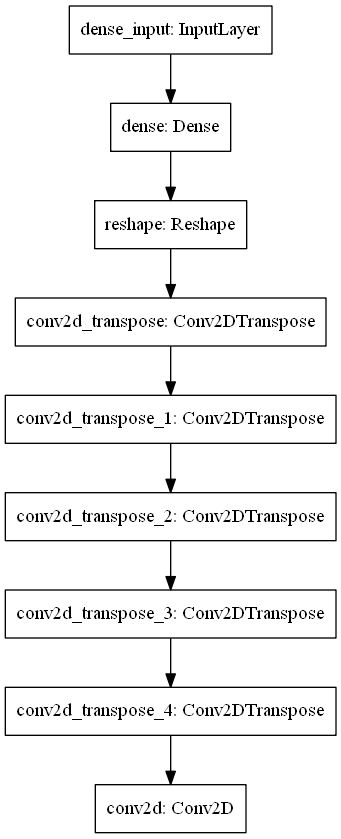

In [27]:
tf.keras.utils.plot_model(
    generator,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)